In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from dateutil import parser

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import ttest_ind

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [6]:
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#read into Pandas DF
measurement_df = pd.read_sql('SELECT * FROM measurement',connection)
station_df = pd.read_sql('SELECT * FROM station',connection)

In [12]:
# Find max date with session query
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
#Hardcode date
hard_date = dt.date(2017, 8 ,23)

In [14]:
#Calculate 1 year ago from hard coded date
year_ago = hard_date - dt.timedelta(days=365)

In [15]:
#Set columns into variable
sel = [Measurement.date, Measurement.prcp]

#extract data into list using the sel variable
precip_last_year = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= year_ago)

#turn list into dataframe sorted by date
precip_last_year_df = pd.DataFrame(precip_last_year).sort_values(by=['date'])

In [16]:
#reset index to date
precip_last_year_df.set_index('date', inplace=True)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


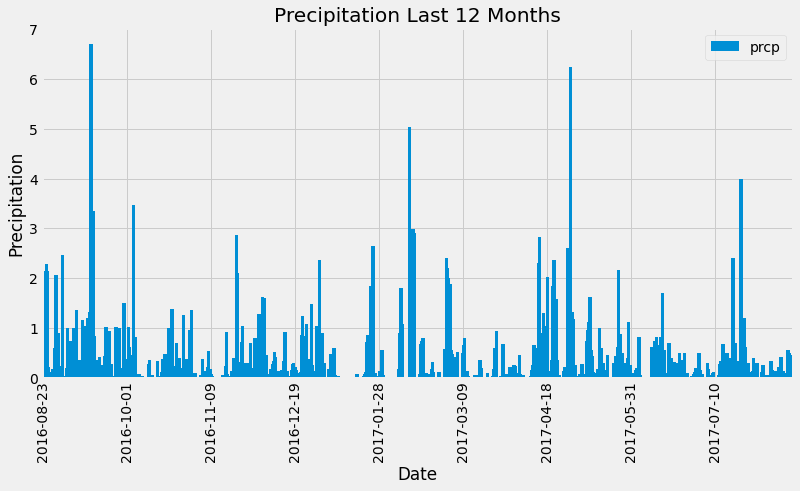

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plot the precipitation for the past 12 months
ax = precip_last_year_df.plot(kind='bar', width=10, figsize=(12,6))
ax.tick_params(axis='y')
plt.title("Precipitation Last 12 Months")
plt.ylabel("Precipitation")
plt.xlabel("Date")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

In [19]:
# Design a query to show how many stations are available in this dataset?
station_no = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {station_no} active weather stations in Hawaii.")

There are 9 active weather stations in Hawaii.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = (session
                   .query(Measurement.station, func.count(Measurement.tobs))
                   .order_by(func.count(Measurement.tobs).desc())
                   .group_by(Measurement.station)
                   .all())

#Use "from records" to create dataframe to get around errors
station_activity = pd.DataFrame.from_records(station_activity, columns=["Station ID","Activity"])
station_activity

,Station ID,Activity
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
# List the most active station
most_active_station = (session
                   .query(Measurement.station, func.count(Measurement.date))
                   .order_by(func.count(Measurement.date).desc())
                   .group_by(Measurement.station)
                   .first())

result = [str(station) for station in most_active_station]

# Extract station from result string
station = result[0]

print(f"The busiest station in Hawaii is Station ID: {station}")

The busiest station in Hawaii is Station ID: USC00519281


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

busy_station = session.query(*sel).\
    filter(Measurement.station == station).all()

print(f"The busiest station {station} had a lowest recorded temperature of {busy_station[0][0]}, a maximum recorded temperature of {busy_station[0][1]} and an average recorded temperature of {busy_station[0][2]}")

The busiest station USC00519281 had a lowest recorded temperature of 54.0, a maximum recorded temperature of 85.0 and an average recorded temperature of 71.66378066378067


In [23]:
# Choose the station with the highest number of temperature observations.
#Set columns into variable
sel = [Measurement.date, Measurement.tobs]

#extract data into list using the sel variable
station_temp_last_year = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= year_ago).\
    filter(Measurement.station == station).\
    order_by(Measurement.date).all()

#turn list into dataframe sorted by date
station_temp_last_year = pd.DataFrame(station_temp_last_year)
station_temp_last_year

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


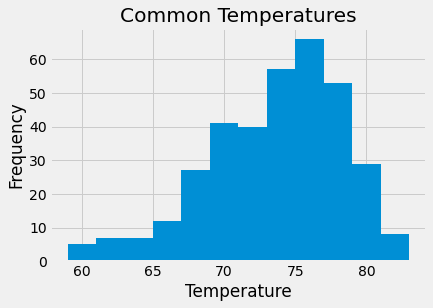

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_last_year.hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Common Temperatures")
plt.show()

## Bonus Challenge Assignment - Temperature Analysis I


In [25]:
#Calculate the average across all temperatures recorded for June & December

temp_sel = [func.avg(Measurement.tobs)]
june_averages = session.query(*temp_sel).\
                              filter(func.strftime("%m", Measurement.date) == "06").all()

dec_averages = session.query(*temp_sel).\
                              filter(func.strftime("%m", Measurement.date) == "12").all()

#Print the average temperatures
print(f"The Average temperature across all June records is {june_averages[0][0]}")
print(f"The Average temperature across all December records is {dec_averages[0][0]}")

The Average temperature across all June records is 74.94411764705882
The Average temperature across all December records is 71.04152933421226


In [26]:
#Extract all June & December data points
june_tobs = session.query(Measurement.tobs).\
                              filter(func.strftime("%m", Measurement.date) == "06").all()

dec_tobs = session.query(Measurement.tobs).\
                              filter(func.strftime("%m", Measurement.date) == "12").all()

In [27]:
#run independent t-test for the June & December datasets
p_test = stats.ttest_ind(june_tobs, dec_tobs, equal_var=False)
p_test

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

In [28]:
print(f"The pvalue shows a statistically insignificant difference in temperature between June and December, coming in at {p_test[1][0]}")

The pvalue shows a statistically insignificant difference in temperature between June and December, coming in at 4.193529835915755e-187


## Bonus Challenge Assignment - Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
#Setup dates for preferred Hawaiian holiday

#Hardcode date
hol_start_hard = dt.date(2013, 8 ,22)
hol_end_hard = dt.date(2013, 8 ,29)

#Calculate 1 year ago from hard coded dates
one_year_ago_start = hol_start_hard - dt.timedelta(days=365)
one_year_ago_end = hol_end_hard - dt.timedelta(days=365)

In [31]:
#Calculate stats for one year ago
last_year_comp = calc_temps(one_year_ago_start, one_year_ago_end)
last_year_comp_min = last_year_comp[0][0]
last_year_comp_max = last_year_comp[0][2]
last_year_comp_avg = last_year_comp[0][1]

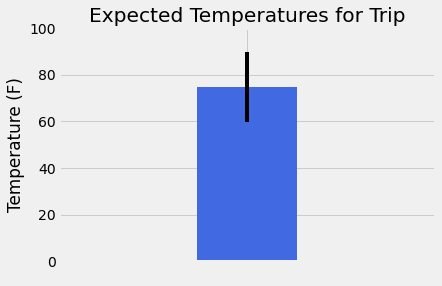

In [32]:
yerr = last_year_comp_max-last_year_comp_min
# Use the average temperature for the y value
plt.bar(" ", last_year_comp_avg, yerr=yerr, color='royalblue')
plt.title("Expected Temperatures for Trip")
plt.ylabel("Temperature (F)")
plt.xlim(-1.5, 1.5)
plt.ylim(0,100)
plt.show()

## Bonus Challenge Assignment - Rain Analysis

In [33]:
#Set rain select function
rain_sel = [Station.station, Station.name,
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ]

#Generate rain list
stationRain_list = session.query(*rain_sel).\
                   filter(Measurement.station == Station.station).\
                   filter(Measurement.date >= one_year_ago_start).\
                   filter(Measurement.date <= one_year_ago_end).\
                   group_by(Station.station).\
                   order_by(func.sum(Measurement.prcp).desc()).all()

#convert query object to data frame
stationRain_list

#Use "from records" to create dataframe to get around errors
pd.DataFrame.from_records(stationRain_list, columns=["Station ID","Station Name", "Total Precipitation","Latitude","Longitude","Elevation"])


,Station ID,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",2.95,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.84,21.45167,-157.84889,32.9
2,USC00519397,"WAIKIKI 717.2, HI US",1.07,21.27160,-157.81680,3.0
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.28,21.52130,-157.83740,7.0
4,USC00513117,"KANEOHE 838.1, HI US",0.21,21.42340,-157.80150,14.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.14,21.33556,-157.71139,19.5
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.04,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",NaN,21.49920,-158.01110,306.6
